# Semantic Segmentation

### Import frameworks, libraries and modules

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy import io

In [2]:
# Use tf.test.is_built_with_cuda() to validate if TensorFlow was built with CUDA support.
tf.test.is_built_with_cuda()

True

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0],True)

# Download and prepare data

### Download masks

In [5]:
# ## OS ####
path_mask_folder = os.path.pardir+os.sep+'lib'+os.sep+'MASKS'
path_mask_folder

'..\\lib\\MASKS'

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# path_mask_folder = '/content/drive/MyDrive/Diploma/MASKS'

In [8]:
mask_path = []

for root, dirs, files in os.walk(path_mask_folder):
    for file in files:
        path = os.path.join(root,file)
        mask_path.append(path)
len(mask_path)

1004

### Download images

In [9]:
### OS ###
path_images_folder = os.path.pardir+os.sep+'lib'+os.sep+'IMAGES'
path_images_folder

'..\\lib\\IMAGES'

In [10]:
# path_images_folder = '/content/drive/MyDrive/Diploma/IMAGES'

In [11]:
image_path_ = []

for root, dirs, files in os.walk(path_images_folder):
    for file in files:
        path = os.path.join(root,file)
        image_path_.append(path)
len(image_path_)

2097

### Sorting the masks to match the image

In [12]:
mask_path.sort()

In [13]:
image_path_.sort()

### Separating the training set associated with the masks

In [14]:
image_path = image_path_[:len(mask_path)]

In [15]:
len(image_path)

1004

### Reading masks and images

In [16]:
with tf.device('/CPU:0'):
    images = []

    for path in image_path:
        file = tf.io.read_file(path)
        image = tf.image.decode_png(file, channels=3, dtype=tf.uint8)
        images.append(image)

    masks = []

    for path in mask_path:
        file = tf.io.read_file(path)
        mask = tf.image.decode_png(file, channels=1, dtype=tf.uint8)
        masks.append(mask)

### Sample few images and visualize

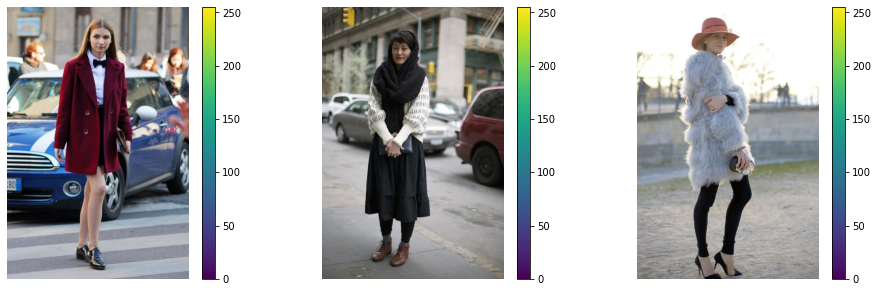

In [17]:
plt.figure(figsize=(16,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[60+i]
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')
plt.show()

Изображения ярлыков имеют 59 сегментированных классов, 
соответствующих таким классам, как волосы, сумка, рубашка, обувь, кожа, 
солнцезащитные очки и кепка.

### Sample corresponding masks and visualize

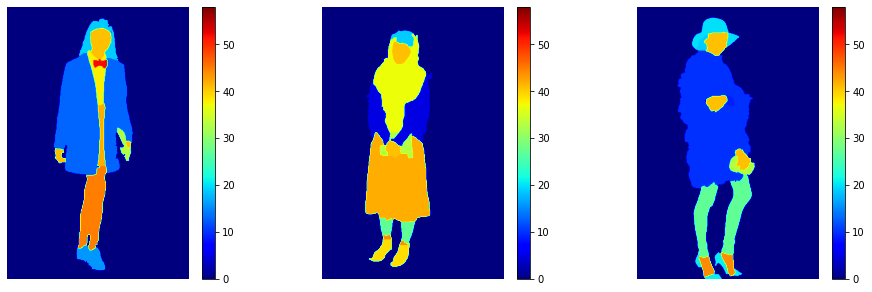

In [18]:
with tf.device('/CPU:0'):
    norm = mpl.colors.Normalize(vmin=0, vmax=58)

    plt.figure(figsize=(16,5))
    for i in range(1,4):
        plt.subplot(1,3,i)
        img = masks[60+i]
        plt.imshow(tf.squeeze(img), cmap='jet', norm=norm)
        plt.colorbar()
        plt.axis('off')
    plt.show()

### Download masks label

In [19]:
### OS ####
path_pixel_level = os.path.pardir+os.sep+'lib'+os.sep+'clothing-co-parsing' \
                                                        +os.sep+'annotations'+os.sep+'pixel-level'
path_pixel_level

'..\\lib\\clothing-co-parsing\\annotations\\pixel-level'

In [20]:
# num_mask = label_list.shape[0]
# num_mask

In [21]:
# label_list = pd.read_csv('/content/drive/MyDrive/Diploma/labels.csv')
# label_list.head()

In [22]:
# pixel_level_of_images = []

# for root, dirs, files in os.walk(path_pixel_level):
#     pixel_level_of_images.append(len(files))
    
# segmentations = []

# for i in range(1,pixel_level_of_images[0]+1):
    
#     url = path_pixel_level+os.sep+ '%04d.mat'%(i)
    
#     # Чтение файлов .ma
#     file = io.loadmat(url)
#     mask = tf.convert_to_tensor(file['groundtruth'])
#     # resize ожидает 3D-изображения, но мы получили 2D-изображение в оттенках серого
#     mask = tf.expand_dims(mask,-1)
#     mask = tf.image.resize_with_crop_or_pad(mask,825,550)
#     segmentations.append(mask)
    
# list_unique_mask = np.unique(tf.squeeze(segmentations))

# if min(list_unique_mask)==0:
#     num_mask = max(list_unique_mask)+1

In [23]:
num_mask = 59

## Build Downstack with a Pre-trained CNN

In [24]:
with tf.device('/CPU:0'):
    DenseNet121_base = keras.applications.DenseNet121(input_shape=[256,256,3], 
                                          include_top=False, 
                                          weights='imagenet')

### How many layers does this model have?

In [25]:
# len(DenseNet121_base.layers)

Нам нужно определить подходящие слои, вывод которых будет использоваться для пропуска соединений.  
Выбираем слои активации ReLU для каждого размера карты функций, то есть 4, 8, 16, 32 и 64, необходимых для пропуска подключений.

In [26]:
# DenseNet121_base.summary()

In [27]:
skip_names = []
for layer in tuple(DenseNet121_base.layers):
        layer_type = type(layer).__name__
        if hasattr(layer, 'activation'):
            if layer_type != "Conv2D":   
                if not layer.name.__contains__('block'):
                    skip_names.append(layer.name) 

In [28]:
skip_names

['conv1/relu', 'pool2_relu', 'pool3_relu', 'pool4_relu', 'relu']

### Obtain the outputs of these layers.

In [29]:
skip_outputs = [] 

for name in skip_names:
    relu = DenseNet121_base.get_layer(name).output
    print('{} : {}'.format(name, relu.shape))
    skip_outputs.append(relu)

conv1/relu : (None, 128, 128, 64)
pool2_relu : (None, 64, 64, 256)
pool3_relu : (None, 32, 32, 512)
pool4_relu : (None, 16, 16, 1024)
relu : (None, 8, 8, 1024)


### Build the downstack with the above layers. 

In [30]:
with tf.device('/CPU:0'):
    downstack = keras.Model(inputs=DenseNet121_base.input,
                           outputs=skip_outputs)
    # freeze the downstack layers
    downstack.trainable = False

# Build Upstack

### Build the up stack using  pix2pix

In [31]:
# pip install -q git+https://github.com/tensorflow/examples.git

In [32]:
from tensorflow_examples.models.pix2pix import pix2pix

In [33]:
with tf.device('/CPU:0'):
    # Four upstack layers for upsampling sizes 
    # 4->8, 8->16, 16->32, 32->64 
    up_stack = [pix2pix.upsample(1024,3),
              pix2pix.upsample(512,3),
              pix2pix.upsample(256,3),
              pix2pix.upsample(128,3)]

In [34]:
up_stack[0].layers

# Build U-Net model with skip-connections

In [35]:
OUTPUT_CHANNELS = 3

In [36]:
tf.debugging.set_log_device_placement(True)
 
def Model(up_stack, downsample):



    inputs = keras.layers.Input(shape=[256,256,3])

    down = downstack(inputs)
    out = down[-1]

    # prepare skip-connections
    skips = reversed(down[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        out = up(out)
        out = tf.keras.layers.Concatenate()([out, skip])

    initializer = tf.random_normal_initializer(0., 0.02)
    # image 128 by 128 with 59 classes
    out = keras.layers.Conv2DTranspose(num_mask, OUTPUT_CHANNELS,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='tanh')(out)  # (batch_size, 256, 256, 3)

    model = tf.keras.Model(inputs=inputs, outputs=out)

    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy']) 

    return model

In [37]:
with tf.device('/CPU:0'):
    model = Model(up_stack, downstack)

### Let's plot our model

In [38]:
# keras.utils.plot_model(unet, show_shapes=True)

# Data Preprocessing

In [39]:
images[0].shape, masks[0].shape

(TensorShape([825, 550, 3]), TensorShape([825, 550, 1]))

### Resize data as the model expects. 

In [40]:
with tf.device('/CPU:0'):
    def resize_image(image):
        # scale the image
        image = tf.cast(image, tf.float32)
        image = image/255.0
        # resize image
        image = tf.image.resize(image, (256,256))
        return image

    def resize_mask(mask):
        # resize the mask
        mask = tf.image.resize(mask, (256,256))
        mask = tf.cast(mask, tf.uint8)
        return mask    

In [41]:
with tf.device('/CPU:0'):
    X = [resize_image(i) for i in images]
    y = [resize_mask(m) for m in masks]
    len(X), len(y)

In [42]:
images[0].dtype, masks[0].dtype, X[0].dtype, y[0].dtype

(tf.uint8, tf.uint8, tf.float32, tf.uint8)

### Visualize a resized image and a resized mask

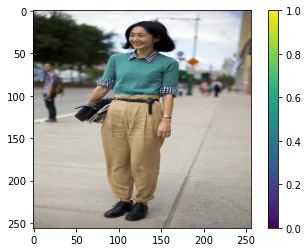

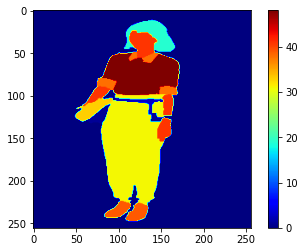

In [43]:
with tf.device('/CPU:0'):
    # plot an image
    plt.imshow(X[57])
    plt.colorbar()
    plt.show()

    #plot a mask
    plt.imshow(tf.squeeze(y[57]), cmap='jet')
    plt.colorbar()
    plt.show()

# Split Data for training and validation

Разделим данные на набор для обучения и проверки в соотношении 80/20.  
Обвернем данные в  объекты TensorFlow Dataset для обучающих и проверочных наборов, чтобы упростить дальнейшую обработку данных.

In [44]:
with tf.device('/CPU:0'):
    from sklearn.model_selection import train_test_split
    # split data into 80/20 ratio
    train_X, val_X,train_y, val_y = train_test_split(X, y, test_size=0.2, 
                                                          random_state=0
                                                         )
    # С помощью tf.data.Dataset.from_tensor_slices() метода мы можем получить срезы массива
    train_X = tf.data.Dataset.from_tensor_slices(train_X)
    val_X = tf.data.Dataset.from_tensor_slices(val_X)

    train_y = tf.data.Dataset.from_tensor_slices(train_y)
    val_y = tf.data.Dataset.from_tensor_slices(val_y)

    # verify the shapes and data types
    train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

In [45]:
len(list(val_X.as_numpy_iterator()))

201

# Data Augmentation 

У нас меньше данных (всего 800 примеров в обучающей выборке), которых недостаточно для глубокого обучения. Следовательно, мы должны увеличить объем обучающих данных, выполняя приращения данных. Определим функции для увеличения данных.

In [46]:
def brightness(img, mask):
    # adjust brightness of image
    # don't alter in mask
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

def gamma(img, mask):
    # adjust gamma of image
    # don't alter in mask
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def hue(img, mask):
    # adjust hue of image
    # don't alter in mask
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    # crop both image and mask identically
    img = tf.image.central_crop(img, 0.7)
    # resize after cropping
    img = tf.image.resize(img, (256,256))
    mask = tf.image.central_crop(mask, 0.7)
    # resize afer cropping
    mask = tf.image.resize(mask, (256,256))
    # cast to integers as they are class numbers
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def flip_hori(img, mask):
    # flip both image and mask identically
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    # flip both image and mask identically
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(img, mask):
    # rotate both image and mask identically
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

Объединим исходный обучающий набор с расширенным новым набором. Не выполняйте увеличение данных с набором проверки.   
У нас есть 7 функций и 800 примеров ввода. 7 * 800 = 5600 новых примеров.  
Включая оригинальные примеры, получаем 5600 + 800 = 6400 примеров для обучения.  

In [47]:
# zip images and masks
with tf.device('/CPU:0'):
    train = tf.data.Dataset.zip((train_X, train_y))
    val = tf.data.Dataset.zip((val_X, val_y))

    # perform augmentation on train data only

    a = train.map(brightness)
    b = train.map(gamma)
    c = train.map(hue)
    d = train.map(crop)
    e = train.map(flip_hori)
    f = train.map(flip_vert)
    g = train.map(rotate)

    # concatenate every new augmented sets
    train = train.concatenate(a)
    train = train.concatenate(b)
    train = train.concatenate(c)
    train = train.concatenate(d)
    train = train.concatenate(e)
    train = train.concatenate(f)
    train = train.concatenate(g)

## Efficient training

In [48]:
BATCH = 32

BUFFER = 800

STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH

#### cache

Кэширует элементы в этом наборе данных.  

При первом повторении набора данных его элементы будут кэшироваться либо в указанном файле, либо в памяти.  
Последующие итерации будут использовать кешированные данные.  

#### shuffle

Случайным образом перемешивает элементы этого набора данных.  

Этот набор данных заполняет буфер `buffer_size` элементами, а затем произвольно  
выбирает элементы из этого буфера, заменяя выбранные элементы новыми элементами.   
Для идеального перемешивания требуется размер буфера больше или равный полному размеру набора данных.  

`reshuffle_each_iterati` onопределяет, должен ли порядок воспроизведения быть разным для каждой эпохи.  

#### batch

Объединяет последовательные элементы этого набора данных в пакеты.  

#### prefetch

Создает объект, Datasetкоторый предварительно выбирает элементы из этого набора данных.  
Если используется значение `tf.data.AUTOTUNE` размер буфера настраивается динамически.

In [49]:
with tf.device('/CPU:0'):
    train = train.cache()
    train = train.shuffle(buffer_size = BUFFER, reshuffle_each_iteration=True)
    train = train.batch(batch_size = BATCH)
    train = train.repeat()
    train = train.prefetch(buffer_size=tf.data.AUTOTUNE)

    val = val.batch(batch_size = BATCH)

# Compiling Model

In [60]:
def Compile_Model():
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy']) 
Compile_Model()

# Training and Fine-tuning

In [52]:
# path_model = os.path.pardir+os.sep+'models'
# path_model

In [53]:
# imported = tf.saved_model.load(path_model)
# outputs = imported(inputs)

In [50]:
hist_1 = model.fit(train,
            validation_data=val,
            steps_per_epoch=STEPS_PER_EPOCH,
            validation_steps=VALIDATION_STEPS,
            epochs=50,
            verbose=2)

Epoch 1/50
25/25 - 38s - loss: 2.7907 - accuracy: 0.7139 - val_loss: 3.2822 - val_accuracy: 0.1416 - 38s/epoch - 2s/step
Epoch 2/50
25/25 - 20s - loss: 2.5058 - accuracy: 0.7753 - val_loss: 2.6380 - val_accuracy: 0.7326 - 20s/epoch - 816ms/step
Epoch 3/50
25/25 - 21s - loss: 2.4533 - accuracy: 0.7877 - val_loss: 2.4949 - val_accuracy: 0.7766 - 21s/epoch - 824ms/step
Epoch 4/50
25/25 - 22s - loss: 2.4979 - accuracy: 0.7437 - val_loss: 2.4290 - val_accuracy: 0.7882 - 22s/epoch - 885ms/step
Epoch 5/50
25/25 - 21s - loss: 2.4775 - accuracy: 0.7542 - val_loss: 2.4265 - val_accuracy: 0.7936 - 21s/epoch - 843ms/step
Epoch 6/50
25/25 - 21s - loss: 2.4227 - accuracy: 0.8001 - val_loss: 2.3915 - val_accuracy: 0.8214 - 21s/epoch - 831ms/step
Epoch 7/50
25/25 - 21s - loss: 2.4158 - accuracy: 0.8058 - val_loss: 2.4233 - val_accuracy: 0.7986 - 21s/epoch - 836ms/step
Epoch 8/50
25/25 - 21s - loss: 2.3997 - accuracy: 0.8201 - val_loss: 2.3956 - val_accuracy: 0.8274 - 21s/epoch - 822ms/step
Epoch 9/50


### Make some prediction and visualize them to evaluate the model qualitatively.

In [56]:
tf.keras.models.save_model(
    model,
    os.path.join(os.path.pardir+os.sep+'models'+ os.sep,'model_DenseNet_50.h5')
)

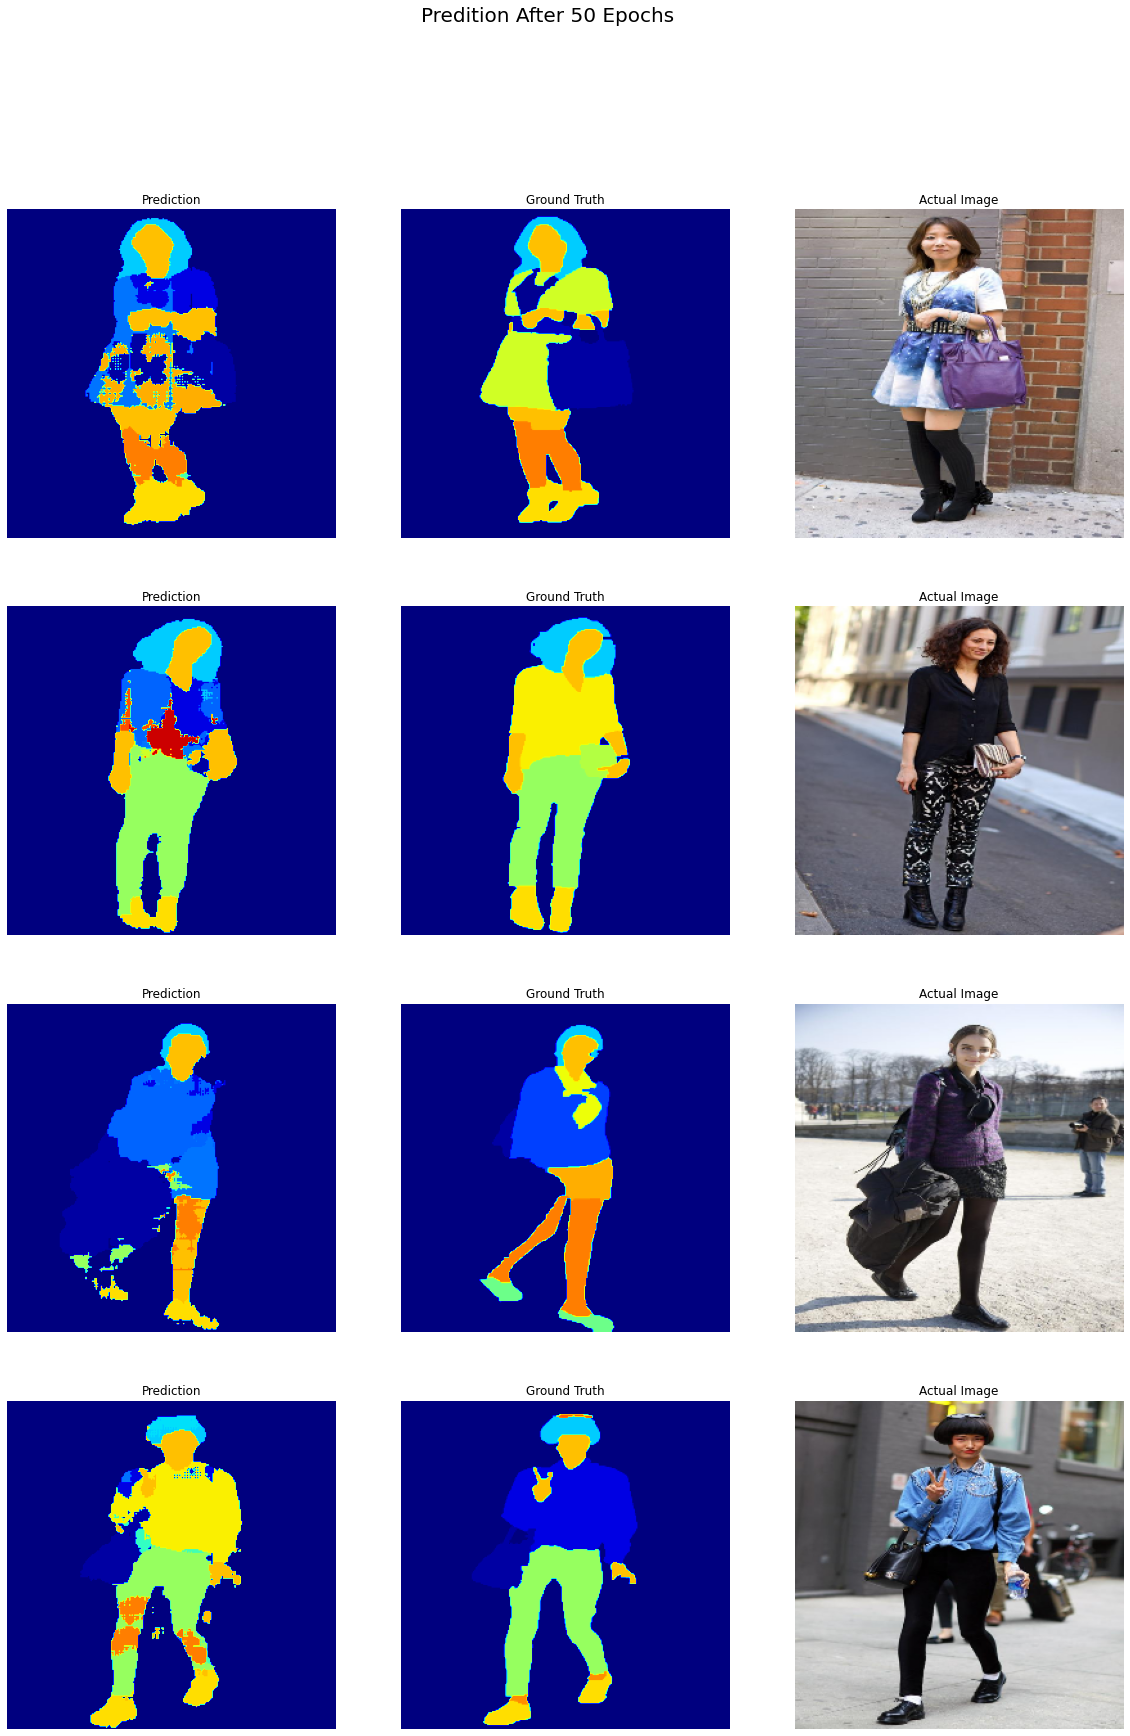

In [58]:
with tf.device('/CPU:0'):
    # select a validation data batch
    img, mask = next(iter(val))
    # make prediction
    pred = model.predict(img)
    plt.figure(figsize=(20,28))

    k = 0
    for i in pred:
        # plot the predicted mask
        plt.subplot(4,3,1+k*3)
        i = tf.argmax(i, axis=-1)
        plt.imshow(i,cmap='jet', norm=norm)
        plt.axis('off')
        plt.title('Prediction')

        # plot the groundtruth mask
        plt.subplot(4,3,2+k*3)
        plt.imshow(tf.squeeze(mask[k]), cmap='jet', norm=norm)
        plt.axis('off')
        plt.title('Ground Truth')

        # plot the actual image
        plt.subplot(4,3,3+k*3)
        plt.imshow(img[k])
        plt.axis('off')
        plt.title('Actual Image')
        k += 1
        if k == 4: break
    plt.suptitle('Predition After 50 Epochs', size=20)  
    plt.show()

# Performance Curves

### Plot the performance curves to understand how the model learnt on the data 

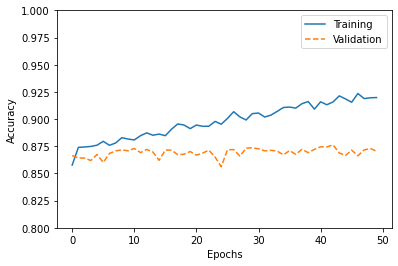

In [163]:
history_2 = hist_2.history
acc=history_2['accuracy']
val_acc = history_2['val_accuracy']

plt.plot(acc[:100], '-', label='Training')
plt.plot(val_acc[:100], '--', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.8,1.0])
plt.legend()
plt.show()